In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
  #   for filename in filenames:
    #     print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
# To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt

# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)

import cv2 as cv
print("Open CV Version :"+cv.__version__)

from PIL import Image

# To be able to use Warning
import warnings
import os
import shutil
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.applications import *
from keras.applications.xception import decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
from keras.layers.core import Dropout

import tensorflow as tf
print("Keras Version : "+tf.keras.__version__)
print("Tensorflow Version : "+tf.__version__)

Python Version :sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.5
Pandas Version :1.1.0
Seaborn Version :0.10.0
Open CV Version :4.3.0
Keras Version : 2.4.0
Tensorflow Version : 2.3.0


In [27]:
images_directory = '/kaggle/input/mydogs/'
train_directory = '/kaggle/input/mydogs/train-small/'
test_directory = '/kaggle/input/mydogs/test-small/'
main_categories = [directory for directory in os.listdir(train_directory)]
main_categories.sort()
batch_size = 32

In [28]:
main_categories

['AfricanHuntingDog',
 'Basset',
 'BouvierDesFlandres',
 'Cardigan',
 'Dingo',
 'FrenchBulldog',
 'Kelpie',
 'Malinois',
 'OldEnglishSheepdog',
 'Redbone',
 'SaintBernard',
 'TibetanTerrier']

In [29]:
number_of_categories = len(main_categories)

# Split among the Train / Test / Validation images¶

In [30]:
train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
transformation_ratio = .05
# train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=transformation_ratio, shear_range=transformation_ratio, zoom_range=transformation_ratio, cval=transformation_ratio, horizontal_flip=True, vertical_flip=True, validation_split=0.2)

# train_datagen = ImageDataGenerator(
  #  rescale=1/255,
  #  rotation_range=40,
  #  width_shift_range=0.2,
  #  height_shift_range=0.2,
  #  shear_range=0.2,
  #  zoom_range=0.2,
  #  horizontal_flip=True,
  #  validation_split=0.2
#)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [31]:
train_generator = train_datagen.flow_from_directory(train_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=main_categories, subset='training')

Found 1110 images belonging to 12 classes.


In [32]:
validation_generator = train_datagen.flow_from_directory(train_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=main_categories, subset='validation')

Found 272 images belonging to 12 classes.


In [33]:
test_generator = test_datagen.flow_from_directory(test_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=main_categories, shuffle=False)

Found 578 images belonging to 12 classes.


In [34]:
print("In train_generator ")
for cat in range(len(train_generator.class_indices)):
    print(main_categories[cat], ":\t", list(train_generator.classes).count(cat))
print("")
print("In validation_generator ")
for cat in range(len(validation_generator.class_indices)):
    print(main_categories[cat], ":\t", list(validation_generator.classes).count(cat))
print("")
print("In test_generator ")
for cat in range(len(test_generator.class_indices)):
    print(main_categories[cat], ":\t", list(test_generator.classes).count(cat))

In train_generator 
AfricanHuntingDog :	 96
Basset :	 99
BouvierDesFlandres :	 85
Cardigan :	 88
Dingo :	 88
FrenchBulldog :	 90
Kelpie :	 87
Malinois :	 85
OldEnglishSheepdog :	 96
Redbone :	 84
SaintBernard :	 96
TibetanTerrier :	 116

In validation_generator 
AfricanHuntingDog :	 23
Basset :	 24
BouvierDesFlandres :	 21
Cardigan :	 21
Dingo :	 22
FrenchBulldog :	 22
Kelpie :	 21
Malinois :	 21
OldEnglishSheepdog :	 23
Redbone :	 21
SaintBernard :	 24
TibetanTerrier :	 29

In test_generator 
AfricanHuntingDog :	 50
Basset :	 52
BouvierDesFlandres :	 44
Cardigan :	 46
Dingo :	 46
FrenchBulldog :	 47
Kelpie :	 45
Malinois :	 44
OldEnglishSheepdog :	 50
Redbone :	 43
SaintBernard :	 50
TibetanTerrier :	 61


# Definition of the model

In [35]:
 model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [36]:

model.trainable = False

# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.9)]:
    layer.trainable = False

for layer in model.layers[int(layer_num * 0.9):]:
    layer.trainable = True
x = model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
# Ajouter la nouvelle couche fully-connected pour la classification 7 classes
predictions = Dense(number_of_categories, activation='softmax')(x)

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

In [37]:
print(new_model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [38]:
train_generator.reset()
validation_generator.reset()
# Compiler le modèle
# new_model.compile(loss="categorical_crossentropy", optimizer='nadam', metrics=["accuracy"])
# new_model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
# new_model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.9), metrics=["accuracy"])
new_model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

In [39]:
earlystopping = EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 

In [40]:
model_info = new_model.fit_generator(train_generator, validation_data=validation_generator, epochs=30, verbose=2, callbacks=[earlystopping])

Epoch 1/30
35/35 - 8s - loss: 1.6953 - accuracy: 0.6009 - val_loss: 0.5325 - val_accuracy: 0.9154
Epoch 2/30
35/35 - 7s - loss: 0.5320 - accuracy: 0.9360 - val_loss: 0.2340 - val_accuracy: 0.9375
Epoch 3/30
35/35 - 7s - loss: 0.2397 - accuracy: 0.9577 - val_loss: 0.2080 - val_accuracy: 0.9449
Epoch 4/30
35/35 - 7s - loss: 0.1418 - accuracy: 0.9811 - val_loss: 0.2050 - val_accuracy: 0.9449
Epoch 5/30
35/35 - 7s - loss: 0.0926 - accuracy: 0.9901 - val_loss: 0.2003 - val_accuracy: 0.9412
Epoch 6/30
35/35 - 7s - loss: 0.0771 - accuracy: 0.9910 - val_loss: 0.1881 - val_accuracy: 0.9522
Epoch 7/30
35/35 - 7s - loss: 0.0512 - accuracy: 0.9973 - val_loss: 0.1896 - val_accuracy: 0.9449
Epoch 8/30
35/35 - 7s - loss: 0.0415 - accuracy: 0.9973 - val_loss: 0.1987 - val_accuracy: 0.9485
Epoch 9/30
35/35 - 7s - loss: 0.0355 - accuracy: 0.9973 - val_loss: 0.1976 - val_accuracy: 0.9449
Epoch 10/30
35/35 - 7s - loss: 0.0242 - accuracy: 0.9982 - val_loss: 0.1960 - val_accuracy: 0.9522
Epoch 11/30
35/35 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


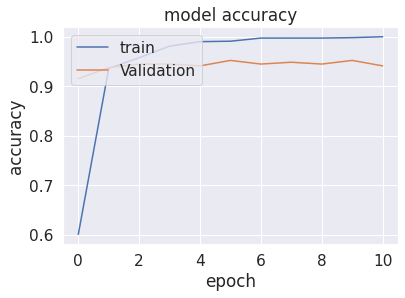

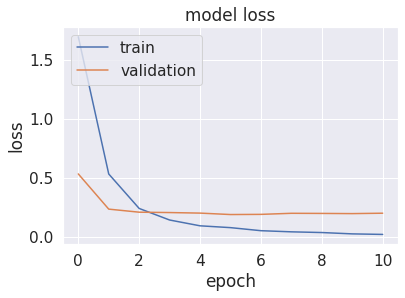

In [41]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['accuracy'])
plt.plot(model_info.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
test_generator.reset()
score = new_model.evaluate_generator(test_generator, (test_generator.samples + (batch_size-1)) // batch_size)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  0.1652527004480362  Accuracy:  0.9532871842384338


In [43]:
test_generator.reset()

testStep = (test_generator.samples + (batch_size-1)) // batch_size
print("testStep: ", testStep)

testStep:  19


In [44]:
Y_pred = new_model.predict_generator(test_generator, steps=testStep, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
print(str(len(y_pred)))
labels = (validation_generator.class_indices)
print("Labels "+(str)(labels))
labels = dict((v, k) for k, v in labels.items())
print(labels)
predictedLabels = [labels[k] for k in y_pred]
#print("Predicted Labels "+(str)(predictedLabels))
len(predictedLabels)
actualLabels = [labels[k] for k in test_generator.classes]
print("Actual Labels "+(str)(actualLabels))
len(actualLabels)

19/19 - 3s
[ 0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  7  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  9  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  2  2  2  2  2  2  5  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2 11 11  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  3  3  3  3  3  3  3  6  3  3  3  3  3  3  6  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  7  4  3  4  4  4  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5
  5  5  5  5  1  5  5  5  3  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6
  6  6  6  6  6  6  6  6  6  4  6  6  6  6  6  6  4  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  3  3  4  6 

578

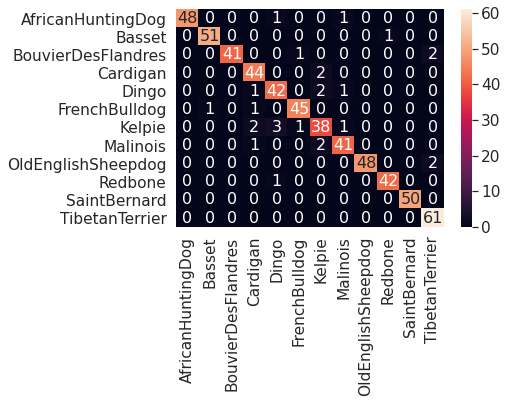

In [45]:
df_cm = pd.DataFrame(confusion_matrix(actualLabels, predictedLabels), main_categories, main_categories)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [46]:
print(classification_report(actualLabels, predictedLabels))

                    precision    recall  f1-score   support

 AfricanHuntingDog       1.00      0.96      0.98        50
            Basset       0.98      0.98      0.98        52
BouvierDesFlandres       1.00      0.93      0.96        44
          Cardigan       0.90      0.96      0.93        46
             Dingo       0.89      0.91      0.90        46
     FrenchBulldog       0.96      0.96      0.96        47
            Kelpie       0.86      0.84      0.85        45
          Malinois       0.93      0.93      0.93        44
OldEnglishSheepdog       1.00      0.96      0.98        50
           Redbone       0.98      0.98      0.98        43
      SaintBernard       1.00      1.00      1.00        50
    TibetanTerrier       0.94      1.00      0.97        61

          accuracy                           0.95       578
         macro avg       0.95      0.95      0.95       578
      weighted avg       0.95      0.95      0.95       578

